In [40]:
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf

In [56]:
import matplotlib.pyplot as plt

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [6]:
x_train[0].shape

(28, 28)

In [7]:
def preprocess(image):
    """Normalize the images"""
    image = image.astype('float32') / 255.0
    image = np.pad(image, ((0,0), (2,2), (2,2)), constant_values=0.0)
    image = np.expand_dims(image, -1)
    return image

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [9]:
IMAGE_SIZE = x_train[0].shape[0]

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE,1), name="encoder_input")

In [19]:
x = layers.Conv2D(32, (3,3), strides = 2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3,3), strides = 2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3,3), strides = 2, activation = "relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
shape_before_flattening_1 = x.shape[1:]

In [26]:
x = layers.Flatten()(x)
z_mean = layers.Dense(2, name="z_mean")(x)
z_log_var = layers.Dense(2, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

In [27]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_10 (Conv2D)             (None, 8, 8, 64)     18496       ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 4, 4, 128)    73856       ['conv2d_10[0][0]']              
                                                                                            

In [28]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="Same")(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), strides =2, activation="relu", padding="same")(x)
decoder_output = layers.Conv2D(1, (2,2), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)

In [29]:
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

In [46]:
BETA = 500

In [47]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
        }


In [48]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [49]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [50]:
vae.fit(
    x_train,
    epochs=5,
    batch_size=100,
    validation_data=(x_test, x_test),
)

Epoch 1/5
600/600 [==============================] - 19s 21ms/step - total_loss: 158.5461 - reconstruction_loss: 153.9110 - kl_loss: 4.6351 - val_loss: 142.0904 - val_reconstruction_loss: 137.0958
Epoch 2/5
600/600 [==============================] - 13s 21ms/step - total_loss: 136.0963 - reconstruction_loss: 131.1049 - kl_loss: 4.9915 - val_loss: 138.0467 - val_reconstruction_loss: 133.0249
Epoch 3/5
600/600 [==============================] - 13s 21ms/step - total_loss: 134.4412 - reconstruction_loss: 129.4217 - kl_loss: 5.0195 - val_loss: 137.0435 - val_reconstruction_loss: 131.8912
Epoch 4/5
600/600 [==============================] - 13s 22ms/step - total_loss: 133.5139 - reconstruction_loss: 128.4501 - kl_loss: 5.0636 - val_loss: 136.4657 - val_reconstruction_loss: 131.3579
Epoch 5/5
600/600 [==============================] - 13s 21ms/step - total_loss: 132.8555 - reconstruction_loss: 127.7677 - kl_loss: 5.0878 - val_loss: 135.5945 - val_reconstruction_loss: 130.5015


In [51]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [52]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

157/157 [==============================] - 1s 5ms/step
Example real clothing items


array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

Reconstructions


array([[[[2.6272272e-07],
         [2.8880041e-08],
         [1.9889265e-08],
         ...,
         [8.8779784e-09],
         [1.0187004e-08],
         [3.9933238e-05]],

        [[1.3375733e-08],
         [2.8154082e-10],
         [1.5766771e-09],
         ...,
         [9.5559383e-10],
         [2.6481792e-09],
         [4.5927582e-06]],

        [[1.0321900e-08],
         [2.4410043e-09],
         [2.2046674e-08],
         ...,
         [1.7216638e-06],
         [4.0647541e-07],
         [1.1758891e-05]],

        ...,

        [[1.4889952e-08],
         [2.7496296e-09],
         [7.8617200e-07],
         ...,
         [3.6918772e-07],
         [4.6933742e-08],
         [3.6624938e-06]],

        [[6.2469629e-09],
         [8.6645618e-10],
         [3.1621749e-08],
         ...,
         [1.3353194e-09],
         [1.6061950e-10],
         [1.1769775e-07]],

        [[8.7385335e-05],
         [6.6784282e-06],
         [1.6049453e-05],
         ...,
         [1.3687820e-06],
        

In [53]:
z_mean, z_var, z = encoder.predict(example_images)

157/157 [==============================] - 1s 3ms/step


In [54]:
# Some examples of the embeddings
print(z[:10])

[[-0.49600592 -1.3378234 ]
 [ 0.7713219   0.03316022]
 [ 1.3366196   1.9127227 ]
 [ 0.3090002   2.469611  ]
 [-0.1368742   0.17731336]
 [ 1.1418725   1.2996519 ]
 [-0.97631645  0.49979243]
 [-0.5973383   0.45843476]
 [-3.06682    -0.4270328 ]
 [-1.8832196  -0.7877438 ]]


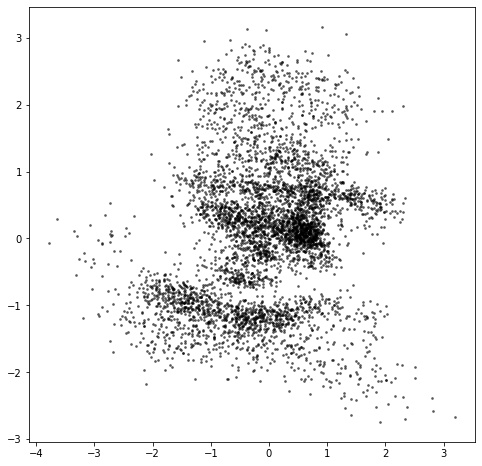

In [57]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()